# House Classification Data Analysis

Datased: [SLICED](https://harsh-walleye-e6e.notion.site/SLICED-Show-c7bd26356e3a42279e2dfbafb0480073) competition, data available in [here](https://www.kaggle.com/c/sliced-s01e11-semifinals/data)

Analyze the Texas housing data, clean it, and predict the **price range** using the nemerial, categorical and text features.

In [2]:
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv('C:/Users/joao/Downloads/train.csv')

In [4]:
dataset.head(5)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,MULTIPLE OFFERS submit best & final to Agent b...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.000000,17,4.0,4,650000+
1,13380,austin,"4644 Hoffman Dr, Austin, TX 78749 is a single ...",Single Family,30.199486,-97.859947,0,False,1997,0,6534.0,6.666667,16,3.0,4,350000-450000
2,4115,austin,"6804 Canal St, Austin, TX 78741 is a single fa...",Single Family,30.227398,-97.696083,0,False,1952,0,5619.0,3.333333,11,1.0,2,0-250000
3,6926,austin,Beautiful large lot with established trees. Lo...,Single Family,30.205469,-97.792351,4,False,1976,0,6416.0,4.000000,14,2.0,4,0-250000
4,14480,austin,Stunning NW Hills designer remodel by Cedar an...,Single Family,30.345106,-97.767426,2,False,1984,0,10759.0,7.000000,16,3.0,5,650000+


# Analysis

In [35]:
dataset['priceRange'].value_counts()

250000-350000    2356
350000-450000    2301
450000-650000    2275
650000+          1819
0-250000         1249
Name: priceRange, dtype: int64

min 1905
max 2020


(array([  19.,   56.,  162.,  342.,  749., 1055., 1920., 1255., 2601.,
        1841.]),
 array([1905. , 1916.5, 1928. , 1939.5, 1951. , 1962.5, 1974. , 1985.5,
        1997. , 2008.5, 2020. ]),
 <BarContainer object of 10 artists>)

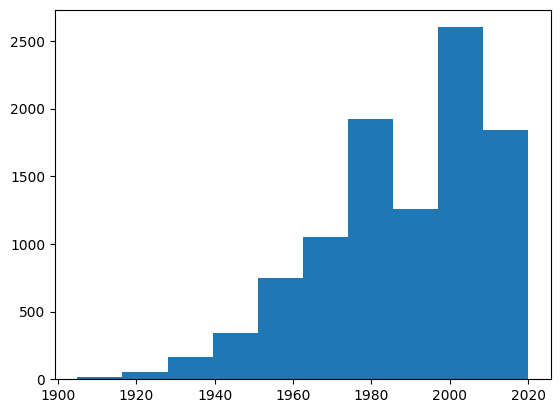

In [52]:
ft = 'yearBuilt'
print('min',np.min(dataset[ft]))
print('max',np.max(dataset[ft]))
plt.hist(dataset[ft])

# Preprocessing

Transformations to be performed:

city: cat

description: nlp

homeType: cat

lat,lng: center tx: 30.2676575,-97.7422388

garageSpaces: > 5, norm

hasSpa: int

yearBuilt: 2024 - yearBuilt, decade (cat)

numOfPatioAndPorchFeatures: > 5, norm

lotSizeSqFt: > 30000, norm

avgSchoolRating: norml

MedianStudentsPerTeacher: norm

numOfBathrooms: > 5, norm

numOfBedrooms: > 5, norm

priceRange: cat (int)

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [39]:
from geopy import distance

In [121]:
new_dataset = dataset.copy()

In [122]:
label_encoder = OrdinalEncoder().fit(new_dataset[['priceRange']])
new_dataset['priceRange'] = label_encoder.transform(new_dataset[['priceRange']])

In [123]:
new_dataset['age'] = 2024 - new_dataset['yearBuilt']
new_dataset['decade'] = np.floor((new_dataset['yearBuilt']-1900)/10)

In [124]:
new_dataset['hasSpa'] = new_dataset['hasSpa'].astype('int')

In [125]:
new_dataset['big_garageSpaces'] = 0
new_dataset.loc[new_dataset['garageSpaces'] > 5, 'big_garageSpaces'] = 1
new_dataset.loc[new_dataset['garageSpaces'] > 5, 'garageSpaces'] = 5

new_dataset['big_numOfPatioAndPorchFeatures'] = 0
new_dataset.loc[new_dataset['numOfPatioAndPorchFeatures'] > 5, 'big_numOfPatioAndPorchFeatures'] = 1
new_dataset.loc[new_dataset['numOfPatioAndPorchFeatures'] > 5, 'numOfPatioAndPorchFeatures'] = 5

new_dataset['big_lotSizeSqFt'] = 0
new_dataset.loc[new_dataset['lotSizeSqFt'] > 30000, 'big_lotSizeSqFt'] = 1
new_dataset.loc[new_dataset['lotSizeSqFt'] > 30000, 'lotSizeSqFt'] = 30000

new_dataset['big_numOfBathrooms'] = 0
new_dataset.loc[new_dataset['numOfBathrooms'] > 5, 'big_numOfBathrooms'] = 1
new_dataset.loc[new_dataset['numOfBathrooms'] > 5, 'numOfBathrooms'] = 5

new_dataset['big_numOfBedrooms'] = 0
new_dataset.loc[new_dataset['numOfBedrooms'] > 5, 'big_numOfBedrooms'] = 1
new_dataset.loc[new_dataset['numOfBedrooms'] > 5, 'numOfBedrooms'] = 5

In [126]:
center_austin = (30.2676575,-97.7422388)
new_dataset['lat_lng_distance'] = dataset.apply(lambda row: distance.distance(center_austin, (row.latitude, row.longitude)).km, axis=1)

In [127]:
city_encoder = OneHotEncoder().fit(new_dataset[['city']])
home_encoder = OneHotEncoder().fit(new_dataset[['homeType']])
decade_encoder = OneHotEncoder().fit(new_dataset[['decade']])

df_city_enc = pd.DataFrame(city_encoder.transform(new_dataset[['city']]).toarray(), columns=city_encoder.get_feature_names_out())
df_home_enc = pd.DataFrame(home_encoder.transform(new_dataset[['homeType']]).toarray(), columns=home_encoder.get_feature_names_out())
df_decade_enc = pd.DataFrame(decade_encoder.transform(new_dataset[['decade']]).toarray(), columns=decade_encoder.get_feature_names_out())

new_dataset = pd.concat([new_dataset, df_city_enc, df_home_enc, df_decade_enc], axis=1)

In [128]:
new_dataset = new_dataset.drop(columns=['uid','latitude','longitude','yearBuilt','city','homeType','decade'])

In [ ]:
new_dataset.head(5)

# Train Split

In [77]:
from sklearn.model_selection import train_test_split

In [130]:
train, test = train_test_split(new_dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train))
print(len(test))
print(len(val))

6400
2000
1600


# Normalization

In [131]:
arr_norm = ['garageSpaces','age','numOfPatioAndPorchFeatures','lotSizeSqFt','avgSchoolRating','MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms']

std_scaler = StandardScaler()
std_scaler.fit(train[arr_norm])

StandardScaler()

In [132]:
train[arr_norm] = std_scaler.transform(train[arr_norm])
test[arr_norm] = std_scaler.transform(test[arr_norm])
val[arr_norm] = std_scaler.transform(val[arr_norm])

In [ ]:
train.head()

# NLP

In [133]:
vocab_size = 100
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, ngrams=2, standardize='lower_and_strip_punctuation', split='whitespace', output_mode='tf_idf')
vectorize_layer.adapt(train['description'])

# Relevant Features

In [137]:
train.corr()['priceRange']

garageSpaces                      0.182569
hasSpa                            0.170146
numOfPatioAndPorchFeatures        0.154099
lotSizeSqFt                       0.403620
avgSchoolRating                   0.503159
MedianStudentsPerTeacher          0.390113
numOfBathrooms                    0.467260
numOfBedrooms                     0.359399
priceRange                        1.000000
age                               0.025807
big_garageSpaces                  0.031610
big_numOfPatioAndPorchFeatures    0.018921
big_lotSizeSqFt                   0.223700
big_numOfBathrooms                0.157574
big_numOfBedrooms                 0.055928
lat_lng_distance                 -0.100424
city_austin                       0.091527
city_del valle                   -0.117288
city_driftwood                    0.044589
city_dripping springs             0.025735
city_manchaca                    -0.008334
city_pflugerville                -0.051236
city_west lake hills              0.025735
homeType_Ap

# Datasets

In [141]:
ds_train = tf.data.Dataset.from_tensor_slices(((vectorize_layer(train['description'].values), train.drop(columns=['description','priceRange']).values), train['priceRange'].values)).batch(100)
ds_val = tf.data.Dataset.from_tensor_slices(((vectorize_layer(val['description'].values), val.drop(columns=['description','priceRange']).values), val['priceRange'].values)).batch(100)
ds_test = tf.data.Dataset.from_tensor_slices(((vectorize_layer(test['description'].values), test.drop(columns=['description','priceRange']).values), test['priceRange'].values)).batch(100)

In [142]:
for (t, x), y in ds_train.take(1):
    print(t.shape)
    print(x.shape)
    print(y.shape)

(100, 100)
(100, 45)
(100,)


# Model

In [155]:
nlp_input = keras.Input(shape=(100,))
mlp_input = keras.Input(shape=(45,))

x = keras.layers.Dense(64, activation='relu')(nlp_input)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Concatenate()([x, mlp_input])

x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=[nlp_input, mlp_input], outputs=[x])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 64)           6464        ['input_9[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 64)           0           ['dense_10[0][0]']               
                                                                                                  
 input_10 (InputLayer)          [(None, 45)]         0           []                               
                                                                                            

# Training

In [156]:
%%time
history = model.fit(ds_train, validation_data=ds_val, epochs=50, verbose=0)

CPU times: total: 8.66 s
Wall time: 7.57 s


In [157]:
model.evaluate(ds_train)
model.evaluate(ds_val)
model.evaluate(ds_test)

20/20 [==============================] - 0s 1ms/step - loss: 1.0854 - accuracy: 0.5350


[1.085424542427063, 0.5350000262260437]

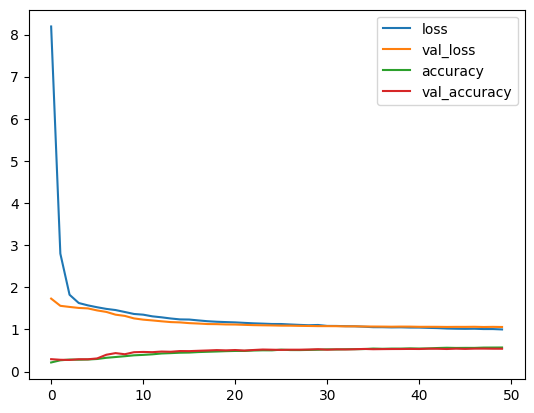

In [158]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [163]:
matrix = sklearn.metrics.confusion_matrix(val['priceRange'], model.predict(ds_val).argmax(axis=1))

16/16 [==============================] - 0s 2ms/step


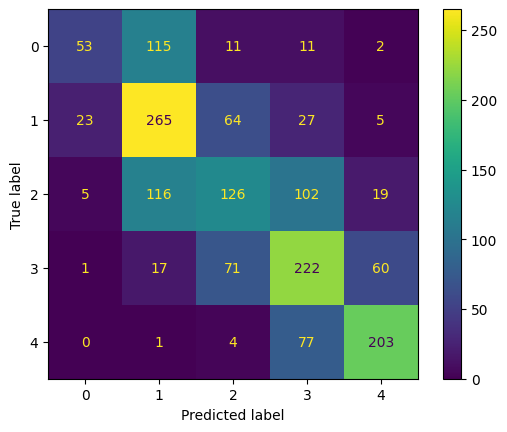

In [164]:
sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()

# Export

In [165]:
import joblib

In [166]:
model.save('pricemodel.h5')

In [171]:
joblib.dump(label_encoder, 'label_encoder.gz')
joblib.dump(city_encoder, 'city_encoder.gz')
joblib.dump(home_encoder, 'home_encoder.gz')
joblib.dump(decade_encoder, 'decade_encoder.gz')
joblib.dump(std_scaler, 'std_scaler.gz')
joblib.dump({'config': vectorize_layer.get_config(), 'weights': vectorize_layer.get_weights()}, 'vectorize_layer.gz')

['vectorize_layer.gz']

# Prediction

In [191]:
# pred_data = dict = {}
def preprocess_data(pred_data):
    city_encoder = joblib.load('city_encoder.gz')
    home_encoder = joblib.load('home_encoder.gz')
    decade_encoder = joblib.load('decade_encoder.gz')
    std_scaler = joblib.load('std_scaler.gz')
    
    vec_config = joblib.load('vectorize_layer.gz')
    print(vec_config['config'])
    vectorize_layer = tf.keras.layers.TextVectorization.from_config(vec_config['config'])
    vectorize_layer.set_weights(vec_config['weights'])
    
    pred_df = pd.DataFrame.from_dict(pred_data)
    
    pred_df['age'] = 2024 - pred_df['yearBuilt']
    pred_df['decade'] = np.floor((pred_df['yearBuilt']-1900)/10)
    
    pred_df['hasSpa'] = pred_df['hasSpa'].astype('int')
    
    pred_df['big_garageSpaces'] = 0
    pred_df.loc[pred_df['garageSpaces'] > 5, 'big_garageSpaces'] = 1
    pred_df.loc[pred_df['garageSpaces'] > 5, 'garageSpaces'] = 5

    pred_df['big_numOfPatioAndPorchFeatures'] = 0
    pred_df.loc[pred_df['numOfPatioAndPorchFeatures'] > 5, 'big_numOfPatioAndPorchFeatures'] = 1
    pred_df.loc[pred_df['numOfPatioAndPorchFeatures'] > 5, 'numOfPatioAndPorchFeatures'] = 5

    pred_df['big_lotSizeSqFt'] = 0
    pred_df.loc[pred_df['lotSizeSqFt'] > 30000, 'big_lotSizeSqFt'] = 1
    pred_df.loc[pred_df['lotSizeSqFt'] > 30000, 'lotSizeSqFt'] = 30000

    pred_df['big_numOfBathrooms'] = 0
    pred_df.loc[pred_df['numOfBathrooms'] > 5, 'big_numOfBathrooms'] = 1
    pred_df.loc[pred_df['numOfBathrooms'] > 5, 'numOfBathrooms'] = 5

    pred_df['big_numOfBedrooms'] = 0
    pred_df.loc[pred_df['numOfBedrooms'] > 5, 'big_numOfBedrooms'] = 1
    pred_df.loc[pred_df['numOfBedrooms'] > 5, 'numOfBedrooms'] = 5
    
    center_austin = (30.2676575,-97.7422388)
    pred_df['lat_lng_distance'] = pred_df.apply(lambda row: distance.distance(center_austin, (row.latitude, row.longitude)).km, axis=1)
    
    df_city_enc = pd.DataFrame(city_encoder.transform(pred_df[['city']]).toarray(), columns=city_encoder.get_feature_names_out())
    df_home_enc = pd.DataFrame(home_encoder.transform(pred_df[['homeType']]).toarray(), columns=home_encoder.get_feature_names_out())
    df_decade_enc = pd.DataFrame(decade_encoder.transform(pred_df[['decade']]).toarray(), columns=decade_encoder.get_feature_names_out())

    pred_df = pd.concat([pred_df, df_city_enc, df_home_enc, df_decade_enc], axis=1)
    
    pred_df = pred_df.drop(columns=['uid','latitude','longitude','yearBuilt','city','homeType','decade'])
    
    arr_norm = ['garageSpaces','age','numOfPatioAndPorchFeatures','lotSizeSqFt','avgSchoolRating','MedianStudentsPerTeacher','numOfBathrooms','numOfBedrooms']
    pred_df[arr_norm] = std_scaler.transform(pred_df[arr_norm])
    
    return tf.data.Dataset.from_tensor_slices(((vectorize_layer(pred_df['description'].values), pred_df.drop(columns=['description']).values),)).batch(100)

def predict_price(pred_dataset):
    model = tf.keras.models.load_model('pricemodel.h5')
    return model.predict(pred_dataset).argmax(axis=1)

# Example of Prediction

In [199]:
new_ds = preprocess_data(dataset[:100].drop(columns=['priceRange']).to_dict())

{'name': 'text_vectorization_2', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'string', 'max_tokens': 100, 'standardize': 'lower_and_strip_punctuation', 'split': 'whitespace', 'ngrams': 2, 'output_mode': 'tf_idf', 'output_sequence_length': None, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': False, 'vocabulary': None, 'idf_weights': None}


In [200]:
new_preds = predict_price(new_ds)

1/1 [==============================] - 0s 43ms/step


In [201]:
label_encoder = joblib.load('label_encoder.gz')
new_labls = label_encoder.inverse_transform(np.expand_dims(new_preds, axis=1))

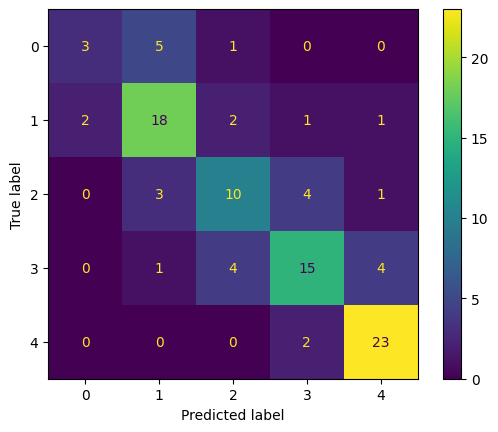

In [202]:
matrix = sklearn.metrics.confusion_matrix(dataset[:100]['priceRange'], new_labls)
sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()